<div style="line-height:0.5">
<h1 style="color:#BAF1CF "> Metrics for classification </h1>
<h4> Compute classic ML classification metrics with numpy and scipy, instead of using std sklearn libraries. </h4>

In [2]:
import numpy as np
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import warnings

In [3]:
def calc_true_positives(y_true, y_pred):
    tp = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 1 and label == 1:
            tp += 1
    return tp

def calc_true_negatives(y_true, y_pred):
    tn = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 0 and label == 0:
            tn += 1
    return tn

def calc_false_positives(y_true, y_pred):
    fp = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 1 and label == 0:
            fp += 1
    return fp

def calc_false_negatives(y_true, y_pred):
    fn = 0
    for label, pred in zip(y_true, y_pred):
        if pred == 0 and label == 1:
            fn += 1
    return fn

def binary_accuracy(y_true, y_pred):
    tp = calc_true_positives(y_true, y_pred)
    tn = calc_true_negatives(y_true, y_pred)
    fp = calc_false_positives(y_true, y_pred)
    fn = calc_false_negatives(y_true, y_pred)
    return (tp + tn) / (tp + tn + fp + fn)

def precision(y_true, y_pred):
    """ Calculate the precision """
    tp = calc_true_negatives(y_true, y_pred)
    fp = calc_false_positives(y_true, y_pred)
    return tp / (tp + fp)

def recall(y_true, y_pred):
    """ Calculate the recall """
    tp = calc_true_negatives(y_true, y_pred)
    fn = calc_false_negatives(y_true, y_pred)
    return tp / (tp + fn)

def multiclass_accuracy(y_true, y_pred):
    """ Calculate accuracy """
    correct = 0
    total = len(y_true)
    for label, pred in zip(y_true, y_pred):
        correct += label == pred
    return correct/total

In [29]:
def confusion_matrix(y_true, y_pred):
    """ Get the confusion matrix. """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert y_true.shape == y_pred.shape
    unique_classes = np.unique(np.concatenate([y_true, y_pred], axis=0)).shape[0]
    cm = np.zeros((unique_classes, unique_classes), dtype=np.int64)
    for label, pred in zip(y_true, y_pred):
        # Convert pred to integer
        cm[label, int(pred)] += 1  
    return cm

In [5]:
def accuracy_cm(cm):
    return np.trace(cm)/np.sum(cm)

def balanced_accuracy_cm(cm):
    correctly_classified = np.diagonal(cm)
    rows_sum = np.sum(cm, axis=1)
    indices = np.nonzero(rows_sum)[0]
    if rows_sum.shape[0] != indices.shape[0]:
        warnings.warn("y_pred contains classes not in y_true")
    accuracy_per_class = correctly_classified[indices]/(rows_sum[indices])
    
    return np.sum(accuracy_per_class)/accuracy_per_class.shape[0]

def precision_cm(cm, average="specific", class_label=1, eps=1e-12):
    tp = np.diagonal(cm)
    fp = np.sum(cm, axis=0) - tp
    #precisions = np.diagonal(cm)/np.maximum(np.sum(cm, axis=0), 1e-12)

    if average == "none":
        return tp/(tp+fp+eps)

    if average == "specific":
        precisions = tp / (tp + fp + eps)
        return precisions[class_label]

    if average == "micro":
        # If all samples equally contribute to the average, there is a distinction between highly and poorly populated classes
        return np.sum(tp) / (np.sum(tp) + np.sum(fp) + eps)

    if average == "macro":
        # If all classes equally contribute to the average, there is no distinction between highly and poorly populated classes
        precisions = tp / (tp + fp + eps)
        return np.sum(precisions)/precisions.shape[0]

    if average == "weighted":
        pass

def recall_cm(cm, average="specific", class_label=1, eps=1e-12):
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp

    if average == "none":
        return tp / (tp + fn + eps)
    if average == "specific":
        recalls = tp / (tp + fn + eps)
        return recalls[class_label]
    if average == "micro":
        return np.sum(tp) / (np.sum(tp) + np.sum(fn))
    if average == "macro":
        recalls = tp / (tp + fn + eps)
        return np.sum(recalls)/recalls.shape[0]
    if average == "weighted":
        pass

def f1score_cm(cm, average="specific", class_label=1):
    precision = precision_cm(cm, average, class_label)
    recall = recall_cm(cm, average, class_label)
    return 2 * (precision*recall)/(precision+recall)

In [6]:
def custom_roc_curve(y_true, y_preds, plot_graph=True, calculate_AUC=True, threshold_step=0.01):
    """ Create ROC.
        - TPR ==> sensitivity ==> recall
        - tnr ==> specificity (which is same as recall for the negative class)
    """
    TPR, FPR = [], []

    for threshold in np.arange(np.min(y_preds), np.max(y_preds), threshold_step):
        predictions = (y_preds > threshold) * 1
        cm = confusion_matrix(y_true, predictions)
        recalls = recall_cm(cm, average="none")
        tpr = recalls[1]
        tnr = recalls[0]
        TPR.append(tpr)
        FPR.append(1-tnr)

    if plot_graph:
        plt.plot(FPR, TPR)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.show()

    if calculate_AUC:
        print(np.abs(np.trapz(TPR, FPR)))

In [7]:
def custom_precision_recall_curve(y_true, y_preds, plot_graph=True, calculate_AUC=True, threshold_step=0.01):
    recalls, precisions = [], []

    for threshold in np.arange(np.min(y_preds), np.max(y_preds), threshold_step):
        predictions = (y_preds > threshold) * 1
        cm = confusion_matrix(y_true, predictions)
        recall = recall_cm(cm, average="specific", class_label=1)
        precision = precision_cm(cm, average="specific", class_label=1)
        recalls.append(recall)
        precisions.append(precision)

    recalls.append(0)
    precisions.append(1)

    if plot_graph:
        plt.plot(recalls, precisions)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall curve")
        plt.show()

    if calculate_AUC:
        print(np.abs(np.trapz(precisions, recalls)))

In [31]:
y, probs = [], []

with open("./data_for_metrics_1.txt") as f:
    for line in f.readlines():
        label, pred = line.split()
        label = int(label)
        pred = float(pred)
        y.append(label)
        probs.append(pred)

In [18]:
tp = calc_true_positives(y, probs)
tn = calc_true_negatives(y, probs)
fp = calc_false_positives(y, probs)
fn = calc_false_negatives(y, probs)

tp, tn, fp, fn

(10, 8, 11, 2)

In [21]:
bc = binary_accuracy(y, probs)
ma = multiclass_accuracy(y, probs)
pr = precision(y, probs)
re = recall(y, probs)

print(f" binary accuracy\n {bc}")
print(f" multiclass accuracy\n {ma}")
print(f" precision\n {pr}")
print(f" recall\n {re}")

 binary accuracy
 0.5806451612903226
 multiclass accuracy
 0.31
 precision
 0.42105263157894735
 recall
 0.8


In [32]:
conf_mat = confusion_matrix(y, probs)

In [35]:
ac_cm = accuracy_cm(conf_mat)
ba_cm = balanced_accuracy_cm(conf_mat)
pr_cm = precision_cm(conf_mat)
re_cm = recall_cm(conf_mat)
f1_cm = f1score_cm(conf_mat)

print(f" accuracy from conf matrix:\n {ac_cm}")
print(f" balanced accuracy from conf matrix:\n {ba_cm}")
print(f" precision from conf matrix:\n {pr_cm}")
print(f" recall from conf matrix:\n {re_cm}")
print(f" f1score from conf matrix:\n {f1_cm}")

 accuracy from conf matrix:
 0.31
 balanced accuracy from conf matrix:
 0.3290562012972879
 precision from conf matrix:
 0.21739130434782136
 recall from conf matrix:
 0.5263157894736565
 f1score from conf matrix:
 0.3076923076922982


In [36]:
# Use float data as predictions
y, probs = [], []
with open("./data_for_metrics_2.txt") as f:
    for line in f.readlines():
        label, pred = line.split()
        label = int(label)
        pred = float(pred)
        y.append(label)
        probs.append(pred)

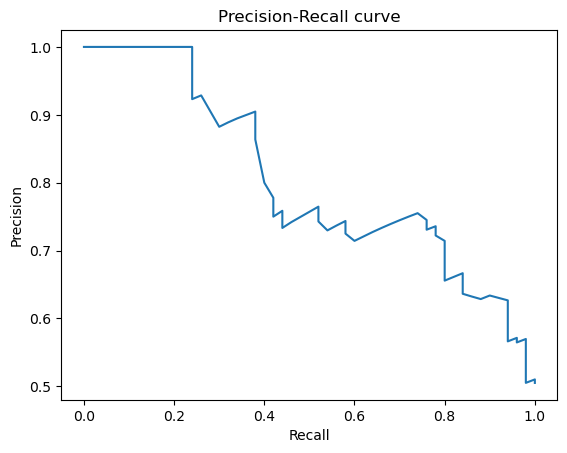

0.801800382104045


In [37]:
custom_precision_recall_curve(y, probs, threshold_step=0.001)

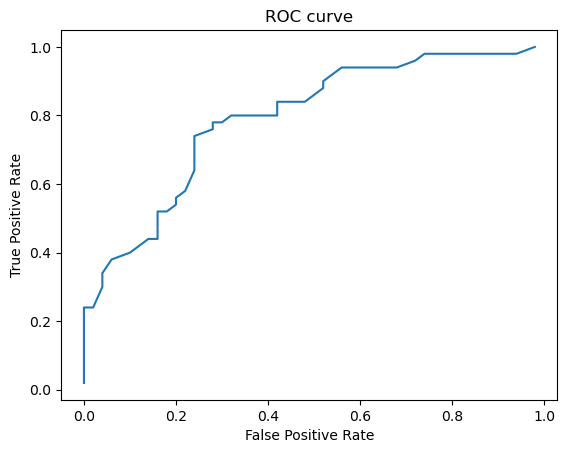

0.771999999999969


In [38]:
custom_roc_curve(y, probs)